## Module 1: Data preparation and customer analytics

#### Conduct analysis on the client's transaction dataset and customer behaviour data. identify customer purchasing behaviours to generate insights and provide commercial recommendations.

Present a strategic recommendation to Julia the Category Manager for chips,supported with data that she can use to make her orders for the upcoming category review. 

#### Analyse the data to understand the current purchasing trends and behaviours. The client is particularly interested in customer segments that makes the most purchases.

#### What metrics would help describe the customers’ purchasing behaviour?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
%matplotlib inline  

## Exploratory Data Analysis:

In [2]:
pr_bhv = pd.read_csv("QVI_purchase_behaviour.csv")
pr_bhv.head(4)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream


In [3]:
pr_bhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
LYLTY_CARD_NBR      72637 non-null int64
LIFESTAGE           72637 non-null object
PREMIUM_CUSTOMER    72637 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [4]:
tr_data = pd.read_excel("QVI_transaction_data.xlsx")
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
DATE              264836 non-null int64
STORE_NBR         264836 non-null int64
LYLTY_CARD_NBR    264836 non-null int64
TXN_ID            264836 non-null int64
PROD_NBR          264836 non-null int64
PROD_NAME         264836 non-null object
PROD_QTY          264836 non-null int64
TOT_SALES         264836 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


### dtypes does not have a date format object

## Merge the dataframes

In [5]:
merged_data = pd.merge(pr_bhv, tr_data, on="LYLTY_CARD_NBR", how="right")
print(merged_data.head())

   LYLTY_CARD_NBR              LIFESTAGE PREMIUM_CUSTOMER   DATE  STORE_NBR  \
0            1000  YOUNG SINGLES/COUPLES          Premium  43390          1   
1            1002  YOUNG SINGLES/COUPLES       Mainstream  43359          1   
2            1003         YOUNG FAMILIES           Budget  43531          1   
3            1003         YOUNG FAMILIES           Budget  43532          1   
4            1004  OLDER SINGLES/COUPLES       Mainstream  43406          1   

   TXN_ID  PROD_NBR                               PROD_NAME  PROD_QTY  \
0       1         5  Natural Chip        Compny SeaSalt175g         2   
1       2        58   Red Rock Deli Chikn&Garlic Aioli 150g         1   
2       3        52   Grain Waves Sour    Cream&Chives 210G         1   
3       4       106  Natural ChipCo      Hony Soy Chckn175g         1   
4       5        96          WW Original Stacked Chips 160g         1   

   TOT_SALES  
0        6.0  
1        2.7  
2        3.6  
3        3.0  
4        1.

In [6]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264836 entries, 0 to 264835
Data columns (total 10 columns):
LYLTY_CARD_NBR      264836 non-null int64
LIFESTAGE           264836 non-null object
PREMIUM_CUSTOMER    264836 non-null object
DATE                264836 non-null int64
STORE_NBR           264836 non-null int64
TXN_ID              264836 non-null int64
PROD_NBR            264836 non-null int64
PROD_NAME           264836 non-null object
PROD_QTY            264836 non-null int64
TOT_SALES           264836 non-null float64
dtypes: float64(1), int64(6), object(3)
memory usage: 22.2+ MB


## Fix the date column

In [7]:
from datetime import date, timedelta
start = date(1899,12,30)

new_date_format = []

for date in merged_data["DATE"]:
    delta = timedelta(date)
    new_date_format.append(start + delta)
    
pd.Series(new_date_format)
    
merged_data["DATE"] = pd.to_datetime(new_date_format)


In [8]:
print(merged_data["DATE"].dtype)
merged_data["DATE"].head(3)

datetime64[ns]


0   2018-10-17
1   2018-09-16
2   2019-03-07
Name: DATE, dtype: datetime64[ns]

## Examine the product names

In [9]:
unique_prod = merged_data["PROD_NAME"].unique()
print(unique_prod[0:4])

['Natural Chip        Compny SeaSalt175g'
 'Red Rock Deli Chikn&Garlic Aioli 150g'
 'Grain Waves Sour    Cream&Chives 210G'
 'Natural ChipCo      Hony Soy Chckn175g']


### Breaking the string into individual components

In [10]:
## Replacing non-word characters like &, / with empty space and remove the numbers
split_prods = merged_data["PROD_NAME"].str.replace(r'([0-9]+[gG])','').str.replace(r'[^\w]', ' ').str.split()
split_prods.head(4)

0           [Natural, Chip, Compny, SeaSalt]
1    [Red, Rock, Deli, Chikn, Garlic, Aioli]
2        [Grain, Waves, Sour, Cream, Chives]
3        [Natural, ChipCo, Hony, Soy, Chckn]
Name: PROD_NAME, dtype: object

In [11]:
split_prods.head(4)

0           [Natural, Chip, Compny, SeaSalt]
1    [Red, Rock, Deli, Chikn, Garlic, Aioli]
2        [Grain, Waves, Sour, Cream, Chives]
3        [Natural, ChipCo, Hony, Soy, Chckn]
Name: PROD_NAME, dtype: object

In [12]:
words_count = {}

def words_countt(line):
    for words in line:
        if words not in words_count:
            words_count[words] = 1
        else:
            words_count[words] += 1

split_prods.apply(lambda line: words_countt(line))
print(pd.Series(words_count).sort_values(ascending=False).head(4))


Chips     49770
Kettle    41288
Smiths    28860
Salt      27976
dtype: int64


## Remove salsa products

In [13]:
s_mask = merged_data["PROD_NAME"].str.contains(r"[sS]alsa")

print(str(len(s_mask)) + "\n")
merged_data = merged_data[~s_mask]
print(len(merged_data)-len(s_mask))

merged_data.info()

264836

-18094
<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 10 columns):
LYLTY_CARD_NBR      246742 non-null int64
LIFESTAGE           246742 non-null object
PREMIUM_CUSTOMER    246742 non-null object
DATE                246742 non-null datetime64[ns]
STORE_NBR           246742 non-null int64
TXN_ID              246742 non-null int64
PROD_NBR            246742 non-null int64
PROD_NAME           246742 non-null object
PROD_QTY            246742 non-null int64
TOT_SALES           246742 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 20.7+ MB


## Anomalies?

In [14]:
merged_data["PROD_QTY"].value_counts(bins=5)

(0.8, 40.8]       246740
(160.2, 200.0]         2
(120.4, 160.2]         0
(80.6, 120.4]          0
(40.8, 80.6]           0
Name: PROD_QTY, dtype: int64

In [15]:
merged_data.sort_values(by="PROD_QTY", ascending=False).head(3)


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
221625,226000,OLDER FAMILIES,Premium,2018-08-19,226,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
221626,226000,OLDER FAMILIES,Premium,2019-05-20,226,226210,4,Dorito Corn Chp Supreme 380g,200,650.0
218544,223025,YOUNG FAMILIES,Mainstream,2018-08-15,223,223075,8,Smiths Crinkle Cut Chips Original 170g,5,14.5


### Transaction ID 226201, 226210 needs to be removed as most of the data falls in the bin (0.8, 40.8]       246738 range

In [16]:
merged_data.drop(labels=tr_data[tr_data["LYLTY_CARD_NBR"] == 226000].index, inplace=True)

## Dates missing?

In [17]:
merged_data["DATE"].describe()

count                  246740
unique                    364
top       2018-12-24 00:00:00
freq                      865
first     2018-07-01 00:00:00
last      2019-06-30 00:00:00
Name: DATE, dtype: object

### A day's transaction is missing. Does this value need to be replaced?

#### Create a DatetimeIndex for all the dates that fall in the year range 2018-07-01 to 2019-06-30

In [18]:
dt_index= pd.date_range(start=merged_data["DATE"].min(), end=merged_data["DATE"].max())
dt_index

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10',
               ...
               '2019-06-21', '2019-06-22', '2019-06-23', '2019-06-24',
               '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28',
               '2019-06-29', '2019-06-30'],
              dtype='datetime64[ns]', length=365, freq='D')

### Do a left merge to check for the missing date

In [19]:
dt_index_df = dt_index.to_frame(index=True)
dt_index_df.head(3)


,0
2018-07-01,2018-07-01
2018-07-02,2018-07-02
2018-07-03,2018-07-03


In [20]:
dt_index_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-07-01 to 2019-06-30
Freq: D
Data columns (total 1 columns):
0    365 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.7 KB


In [21]:
merged_data.head(3)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6


In [22]:
merge=pd.merge(dt_index_df, merged_data, how='outer', left_index=True, right_index=True)
merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247105 entries, 2018-07-01 00:00:00 to 264835
Data columns (total 11 columns):
0                   365 non-null datetime64[ns]
LYLTY_CARD_NBR      246740 non-null float64
LIFESTAGE           246740 non-null object
PREMIUM_CUSTOMER    246740 non-null object
DATE                246740 non-null datetime64[ns]
STORE_NBR           246740 non-null float64
TXN_ID              246740 non-null float64
PROD_NBR            246740 non-null float64
PROD_NAME           246740 non-null object
PROD_QTY            246740 non-null float64
TOT_SALES           246740 non-null float64
dtypes: datetime64[ns](2), float64(6), object(3)
memory usage: 22.6+ MB


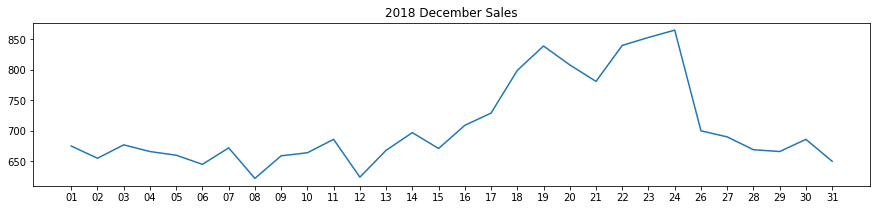

In [23]:
trans_by_date = merge["DATE"].value_counts()
dec = trans_by_date[(trans_by_date.index >= pd.datetime(2018,12,1)) & (trans_by_date.index < pd.datetime(2019,1,1))].sort_index()
dec.index = dec.index.strftime('%d')
ax = dec.plot(figsize=(15,3))
ax.set_xticks(np.arange(len(dec)))
ax.set_xticklabels(dec.index)
plt.title("2018 December Sales")
plt.savefig("2018 December Sales.png", bbox_inches="tight")
plt.show()

In [24]:
t = merged_data["PROD_NAME"].str.replace(r'[0-9]+(G)','g')
t.head(4)

0    Natural Chip        Compny SeaSalt175g
1     Red Rock Deli Chikn&Garlic Aioli 150g
2        Grain Waves Sour    Cream&Chives g
3    Natural ChipCo      Hony Soy Chckn175g
Name: PROD_NAME, dtype: object

count    246740.000000
mean        175.585284
std          59.434946
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: 0, dtype: float64


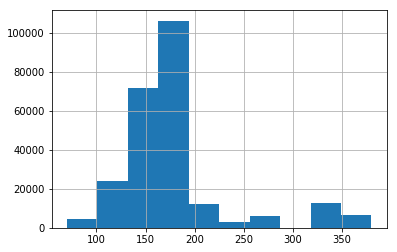

In [25]:
pack_sizes = merged_data["PROD_NAME"].str.extract(r'([0-9]+[gG])')[0].str.replace("[Gg]","").astype(float)
print(pack_sizes.describe())
pack_sizes.hist()

Product size reasonable with highest transaction frequency in mid-sized pack(170G). Smallest size is 70g, and largest size is 380g.

### Create a new column to find most popular item

In [26]:
merged_data["PROD_NAME"].str.split().str[0].value_counts()

Kettle        41286
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: PROD_NAME, dtype: int64

#### Some brands are written in more than 1 way: Dorito and Doritos, Grain and GrnWves, Infuzions and Infzns, Natural and NCC, Red and RRD, Smith and Smiths, Snbts and Sunbites, WW and Woolworths

In [27]:
merged_data["Cleaned_Brand_Names"] = merged_data["PROD_NAME"].str.split().str[0]
merged_data["Cleaned_Brand_Names"].head(4)

0    Natural
1        Red
2      Grain
3    Natural
Name: Cleaned_Brand_Names, dtype: object

In [28]:
def clean_brands(line):
    brand = line["Cleaned_Brand_Names"]
    if brand == "Dorito":
        return "Doritos"
    elif brand == "GrnWves" or brand == "Grain":
        return "Grain Waves"
    elif brand == "Infzns":
        return "Infuzions"
    elif brand == "Natural" or brand == "NCC":
        return "Natural Chip Co"
    elif brand == "Red":
        return "RRD"
    elif brand == "Smith":
        return "Smiths"
    elif brand == "Snbts":
        return "Sunbites"
    elif brand == "WW":
        return "Woolworths"
    else:
        return brand    

In [29]:
merged_data["Cleaned_Brand_Names"] = merged_data.apply(lambda line: clean_brands(line), axis=1)


In [30]:
merged_data["Cleaned_Brand_Names"].head(4)

0    Natural Chip Co
1                RRD
2        Grain Waves
3    Natural Chip Co
Name: Cleaned_Brand_Names, dtype: object

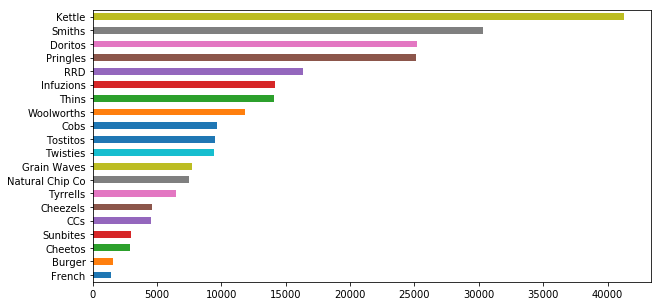

In [31]:
merged_data["Cleaned_Brand_Names"].value_counts(ascending=True).plot.barh(figsize=(10,5))


### Kettle, Smith, Doritos and Pringles are the top 4 sold chips

In [32]:
print(merged_data["LIFESTAGE"].value_counts(), "\n")
print(merged_data["PREMIUM_CUSTOMER"].value_counts())

OLDER SINGLES/COUPLES     50791
RETIREES                  46431
OLDER FAMILIES            45160
YOUNG FAMILIES            40494
YOUNG SINGLES/COUPLES     33969
MIDAGE SINGLES/COUPLES    23398
NEW FAMILIES               6497
Name: LIFESTAGE, dtype: int64 

Mainstream    95043
Budget        86760
Premium       64937
Name: PREMIUM_CUSTOMER, dtype: int64


In [33]:
sales_per_group = merged_data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].agg(["sum", "mean"])
sales_per_group.head(4)
sales_per_group.sort_values(ascending=False, by="sum")


sum      mean
LIFESTAGE              PREMIUM_CUSTOMER                     
OLDER FAMILIES         Budget            156863.75  7.291241
YOUNG SINGLES/COUPLES  Mainstream        147582.20  7.551279
RETIREES               Mainstream        145168.95  7.269352
YOUNG FAMILIES         Budget            129717.95  7.302705
OLDER SINGLES/COUPLES  Budget            127813.60  7.444007
                       Mainstream        124648.50  7.306049
                       Premium           123537.55  7.459997
RETIREES               Budget            105916.30  7.445786
OLDER FAMILIES         Mainstream         96413.55  7.281440
RETIREES               Premium            91296.65  7.461315
YOUNG FAMILIES         Mainstream         86338.25  7.226772
MIDAGE SINGLES/COUPLES Mainstream         84734.25  7.637156
YOUNG FAMILIES         Premium            78571.70  7.285951
OLDER FAMILIES         Premium            76542.60  7.356329
YOUNG SINGLES/COUPLES  Budget             57122.10  6.663023
MIDAGE SINGLES/COUPLES Premium            54443.85  7.152371
YOUNG SINGLES/COUPLES  Premium            39052.30  6.673325
MIDAGE SINGLES/COUPLES Budget             33345.70  7.108442
NEW FAMILIES           Budget             20607.45  7.297256
                       Mainstream         15979.70  7.313364
                       Premium            10760.80  7.231720

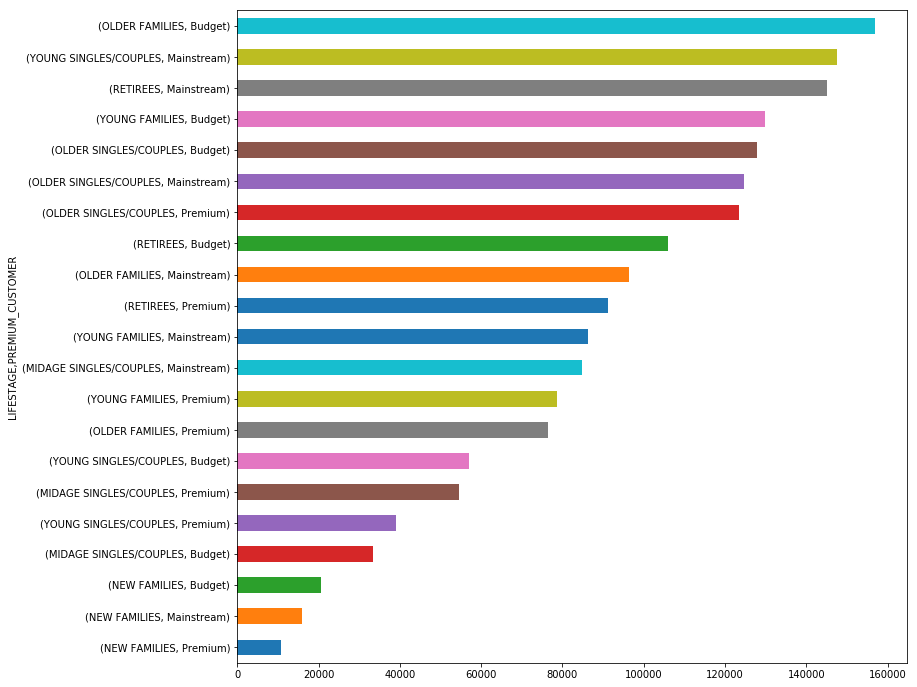

In [34]:
sales_per_group["sum"].sort_values().plot.barh(figsize=(12,12))

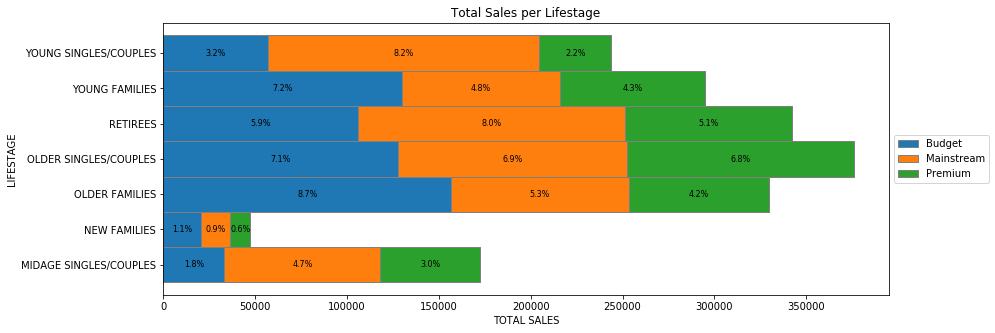

In [35]:
# Values of each group

bars1 = sales_per_group[sales_per_group.index.get_level_values("PREMIUM_CUSTOMER") == "Budget"]["sum"]
bars2 = sales_per_group[sales_per_group.index.get_level_values("PREMIUM_CUSTOMER") == "Mainstream"]["sum"]
bars3 = sales_per_group[sales_per_group.index.get_level_values("PREMIUM_CUSTOMER") == "Premium"]["sum"]
 
bars1_text = (bars1 / sum(sales_per_group["sum"])).apply("{:.1%}".format)
bars2_text = (bars2 / sum(sales_per_group["sum"])).apply("{:.1%}".format)
bars3_text = (bars3 / sum(sales_per_group["sum"])).apply("{:.1%}".format)
 
# Names of group and bar width
names = sales_per_group.index.get_level_values("LIFESTAGE").unique()

# The position of the bars on the x-axis
r = np.arange(len(names))
plt.figure(figsize=(13,5)) 

# Create brown bars
budget_bar = plt.barh(r, bars1, edgecolor='grey', height=1, label="Budget")
# Create green bars (middle), on top of the firs ones
mains_bar = plt.barh(r, bars2, left=bars1, edgecolor='grey', height=1, label="Mainstream")
# Create green bars (top)
prem_bar = plt.barh(r, bars3, left=np.add(bars1, bars2), edgecolor='grey', height=1, label="Premium")
for i in range(7):
    budget_width = budget_bar[i].get_width()
    budget_main_width = budget_width + mains_bar[i].get_width()
    plt.text(budget_width/2, i, bars1_text[i], va='center', ha='center', size=8)
    plt.text(budget_width + mains_bar[i].get_width()/2, i, bars2_text[i], va='center', ha='center', size=8)
    plt.text(budget_main_width + prem_bar[i].get_width()/2, i, bars3_text[i], va='center', ha='center', size=8)
    
# Custom X axis
plt.yticks(r, names)
plt.ylabel("LIFESTAGE")
plt.xlabel("TOTAL SALES")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.title("Total Sales per Lifestage")

plt.savefig("lifestage_sales.png", bbox_inches="tight")

# Show graphic
plt.show()

In [36]:
stage_agg_prem = merged_data.groupby("LIFESTAGE")["PREMIUM_CUSTOMER"].agg(pd.Series.mode).sort_values()
print("Top contributor/LIFESTAGE by PREMIUM category:")
print(stage_agg_prem)

Top contributor/LIFESTAGE by PREMIUM category:
LIFESTAGE
NEW FAMILIES                  Budget
OLDER FAMILIES                Budget
OLDER SINGLES/COUPLES         Budget
YOUNG FAMILIES                Budget
MIDAGE SINGLES/COUPLES    Mainstream
RETIREES                  Mainstream
YOUNG SINGLES/COUPLES     Mainstream
Name: PREMIUM_CUSTOMER, dtype: object
